k=4, silhueta (amostra)=0.0302
k=6, silhueta (amostra)=0.0398
k=8, silhueta (amostra)=0.0420
k=10, silhueta (amostra)=0.0475

Melhor k escolhido: 10 | silhueta(amostra)=0.0475
{
  "0": [
    "accessories",
    "039 accessories",
    "women 039",
    "women",
    "unbranded accessories",
    "size",
    "039",
    "unbranded",
    "size 00",
    "00",
    "scarf size",
    "scarf",
    "belt size",
    "belt",
    "accessories scarf"
  ],
  "1": [
    "model",
    "inch",
    "tool",
    "capacity",
    "amana",
    "amana tool",
    "vestil",
    "carbide",
    "lb capacity",
    "inch model",
    "lb",
    "tipped",
    "carbide tipped",
    "000",
    "ch"
  ],
  "2": [
    "men",
    "men 039",
    "039",
    "short",
    "tees",
    "black",
    "slim",
    "fit",
    "sleeve",
    "short sleeve",
    "cotton",
    "grey",
    "shirt",
    "blue",
    "slim fit"
  ],
  "3": [
    "dresses",
    "dress size",
    "dress",
    "casual dress",
    "casual",
    "039 dresses",
    "ski

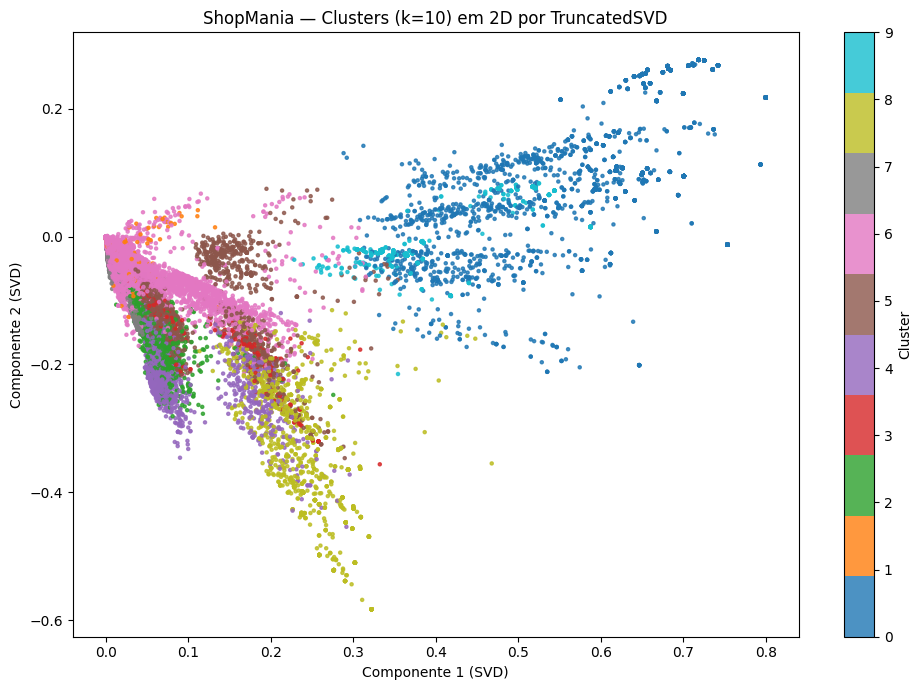

Silhueta final (amostra): 0.0475


In [ ]:
# %% [markdown]
# # Clusterização de Produtos ShopMania com K-Means (Notebook)
# 
# **Tudo em um bloco de dados único; análises estão em comentários dentro das células.**
# 
# Pipeline:
# - Leitura e limpeza dos dados
# - Vetorização TF-IDF de títulos de produtos
# - Escolha de *k* via silhueta (amostra)
# - Treino com MiniBatchKMeans no dataset completo
# - Visualização 2D (TruncatedSVD) da clusterização em amostra
# - **Quantização vetorial**: cada produto é mapeado ao centróide mais próximo (índice do cluster)
# - Extração de termos representativos por cluster
#
# Observações importantes (análise):
# - Para texto curto, TF-IDF com n-gramas (1–2) ajuda a capturar termos compostos (ex.: “eau de”, “kit perfume”).
# - Escolhemos *k* por silhueta (métrica cosseno) em amostra para equilibrar custo x qualidade.
# - MiniBatchKMeans é adequado para bases grandes; centróides são o "codebook" na **quantização vetorial**.
# - A projeção 2D via SVD é apenas ilustrativa; separações reais ocorrem no espaço TF-IDF de alta dimensão.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore", category=UserWarning)

# Configurações reprodutíveis e de desempenho
np.random.seed(42)
csv_path = "shopmania.csv"
max_features_tfidf = 50000
min_df_tfidf = 5
possiveis_k = [4, 6, 8, 10] 
tam_amostra_k = 40000        # amostra para escolha de k
tam_amostra_plot = 30000     # amostra para visualização

# Lista leve de stopwords PT/EN para títulos de produtos
stop_pt = [
    "de","da","do","das","dos","para","com","por","a","o","as","os",
    "e","em","na","no","nas","nos","um","uma","uns","umas","ao","à",
    "que","onde","qual","quais","se","sua","seu","suas","seus"
]
stop_en_extra = ["and", "the", "for", "with"]

# %%
# Leitura do CSV
df_raw = pd.read_csv(csv_path)

# Inferência simples de colunas 
# Assumindo estrutura: ID, Produto, Categoria_ID, Categoria_Nome (como na amostra)
if df_raw.shape[1] >= 4:
    df_raw = df_raw.iloc[:, :4]
    df_raw.columns = ["ID", "Produto", "Categoria_ID", "Categoria_Nome"]
else:
    raise ValueError("Esperava ao menos 4 colunas (ID, Produto, Categoria_ID, Categoria_Nome). Ajuste o notebook para seu CSV.")

# Limpeza básica
df = (df_raw
      .dropna(subset=["Produto"])
      .drop_duplicates(subset=["Produto"])
      .reset_index(drop=True))
df["Produto"] = (df["Produto"].astype(str)
                 .str.replace(r"\s+", " ", regex=True)
                 .str.strip()
                 .str.lower())

# Análise (comentário):
# - Remoção de nulos/duplicados previne ruído e repetição de amostras.
# - Normalização para minúsculas e espaços padroniza o texto.

df.head()

# %%
# Vetorização TF-IDF (matriz esparsa)
vectorizer = TfidfVectorizer(
    stop_words=stop_pt + stop_en_extra,
    ngram_range=(1, 2),
    min_df=min_df_tfidf,
    max_features=max_features_tfidf
)
X = vectorizer.fit_transform(df["Produto"])

# Análise (comentário):
# - ngram_range=(1,2) captura termos simples e compostos.
# - min_df filtra termos muito raros; max_features controla dimensionalidade.

X.shape

# %%
# Escolha de k por silhueta (métrica cosseno) em amostra
n_total = X.shape[0]
idx_k = np.random.choice(n_total, size=min(tam_amostra_k, n_total), replace=False)
X_k = X[idx_k]

melhor_k = None
melhor_sil = -1.0

for k in possiveis_k:
    mbk_tmp = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
        batch_size=2048,
        reassignment_ratio=0.01
    )
    labels_tmp = mbk_tmp.fit_predict(X_k)
    # Silhueta com métrica cosseno é adequada para TF-IDF
    s_tmp = silhouette_score(X_k, labels_tmp, metric="cosine")
    print(f"k={k}, silhueta (amostra)={s_tmp:.4f}")
    if s_tmp > melhor_sil:
        melhor_sil = s_tmp
        melhor_k = k

print(f"\nMelhor k escolhido: {melhor_k} | silhueta(amostra)={melhor_sil:.4f}")

# Análise (comentário):
# - Silhueta próxima a 1 sugere boa separação; ~0 indica sobreposição.
# - Selecionamos o k com maior silhueta em amostra para balancear custo e qualidade.

# %%
# Treinamento final no dataset completo
kmeans = MiniBatchKMeans(
    n_clusters=melhor_k,
    random_state=42,
    n_init="auto",
    batch_size=4096,
    reassignment_ratio=0.01
)
labels_full = kmeans.fit_predict(X)
df["Cluster"] = labels_full

# Distribuição dos clusters
dist = df["Cluster"].value_counts().sort_index()
dist

# Análise (comentário):
# - Distribuição muito desequilibrada pode indicar k inadequado ou temas dominantes.
# - Avalie dist e considere ajustar possiveis_k se necessário.

# %%
# "Quantização vetorial": cada produto -> índice do centróide (cluster)
# Isto reduz um vetor TF-IDF (alta dimensão) a um índice discreto (código do dicionário).
df_quant = df[["ID", "Produto", "Categoria_ID", "Categoria_Nome", "Cluster"]].copy()
df_quant.head(10)

# Análise (comentário):
# - Este mapeamento produto->cluster pode ser usado para categorização rápida,
#   resumo semântico ou busca aproximada por cluster.

# %%
# Termos representativos por cluster (sem função, direto)
termos = np.array(vectorizer.get_feature_names_out())
top_n = 15
top_terms_por_cluster = {}

for c in range(kmeans.n_clusters):
    centroide = kmeans.cluster_centers_[c]
    idx_ord = np.argsort(centroide)[::-1][:top_n]
    # converter para lista nativa (evitar erro de serialização JSON)
    top_terms_por_cluster[int(c)] = termos[idx_ord].tolist()

print(json.dumps(top_terms_por_cluster, ensure_ascii=False, indent=2))

# Análise (comentário):
# - Estes termos ajudam a entender a "temática" de cada cluster (ex.: perfume, camiseta, quadro etc.).
# - Use-os para rotular clusters de forma interpretável.

# %%
# Visualização 2D com TruncatedSVD (em amostra) — rápido para matriz esparsa
idx_plot = np.random.choice(n_total, size=min(tam_amostra_plot, n_total), replace=False)
X_plot = X[idx_plot]
y_plot = labels_full[idx_plot]

svd = TruncatedSVD(n_components=2, random_state=42)
X2 = svd.fit_transform(X_plot)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y_plot, s=5, cmap="tab10", alpha=0.8)
plt.title(f"ShopMania — Clusters (k={melhor_k}) em 2D por TruncatedSVD")
plt.xlabel("Componente 1 (SVD)")
plt.ylabel("Componente 2 (SVD)")
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.tight_layout()
plt.show()

# Análise (comentário):
# - A projeção 2D é ilustrativa; clusters reais estão em alta dimensão.
# - Misturas na projeção não necessariamente implicam má separação no espaço original.

# %%
# Silhueta final em amostra (sanity check)
sil_final = silhouette_score(X_plot, y_plot, metric="cosine")
print(f"Silhueta final (amostra): {sil_final:.4f}")

# Análise (comentário):
# - Compare a silhueta final com a usada na escolha de k.
# - Se o valor estiver muito baixo, avalie: ampliar vocabulário (max_features),
#   ajustar min_df, experimentar outra faixa de k, ou enriquecer os títulos (ex.: categorias).


Registros após limpeza: 303822
Categorias únicas (deveria estar próximo de 230): 190
Shape TF-IDF: (303822, 10000)
[BASE] k=6 | silhueta(cosine)=0.0313
[BASE] k=8 | silhueta(cosine)=0.0261
[BASE] k=10 | silhueta(cosine)=0.0275
[BASE] k=12 | silhueta(cosine)=0.0379
[BASE] k=15 | silhueta(cosine)=0.0429

[BASE] Melhor k: 15 | silhueta=0.0429

Distribuição (BASE):
Cluster_BASE
0      17174
1     150048
2       8575
3       6915
4      14623
5      17998
6      12561
7       6712
8       9156
9       7707
10      9177
11      6683
12      8241
13     10627
14     17625
Name: count, dtype: int64


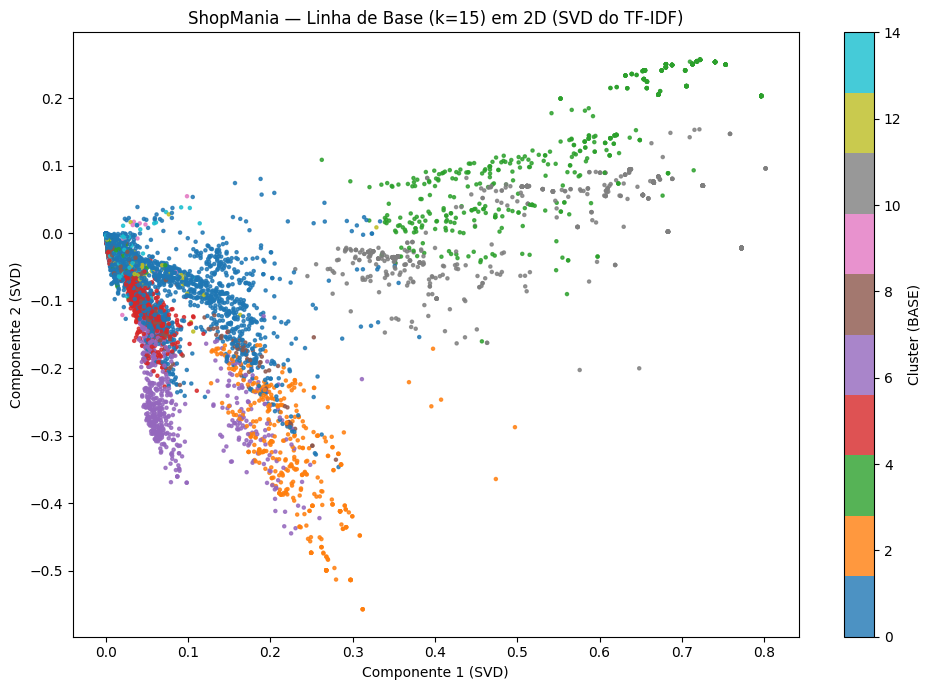

Silhueta (BASE) na amostra do gráfico (cosine): 0.0516
Shape SVD(texto): (303822, 200) | Shape OneHot(categorias): (303822, 190)
Shape após PCA: (303822, 50)
[PCA] k=6 | silhueta(euclidean)=0.1785
[PCA] k=8 | silhueta(euclidean)=0.2460
[PCA] k=10 | silhueta(euclidean)=0.2906
[PCA] k=12 | silhueta(euclidean)=0.3507
[PCA] k=15 | silhueta(euclidean)=0.4405

[PCA] Melhor k: 15 | silhueta=0.4405

Distribuição (PCA):
Cluster_PCA
0       9820
1       8815
2       9928
3     166308
4       9997
5       9878
6       9942
7       9995
8       9844
9       9999
10     10000
11      9898
12      9932
13      9986
14      9480
Name: count, dtype: int64


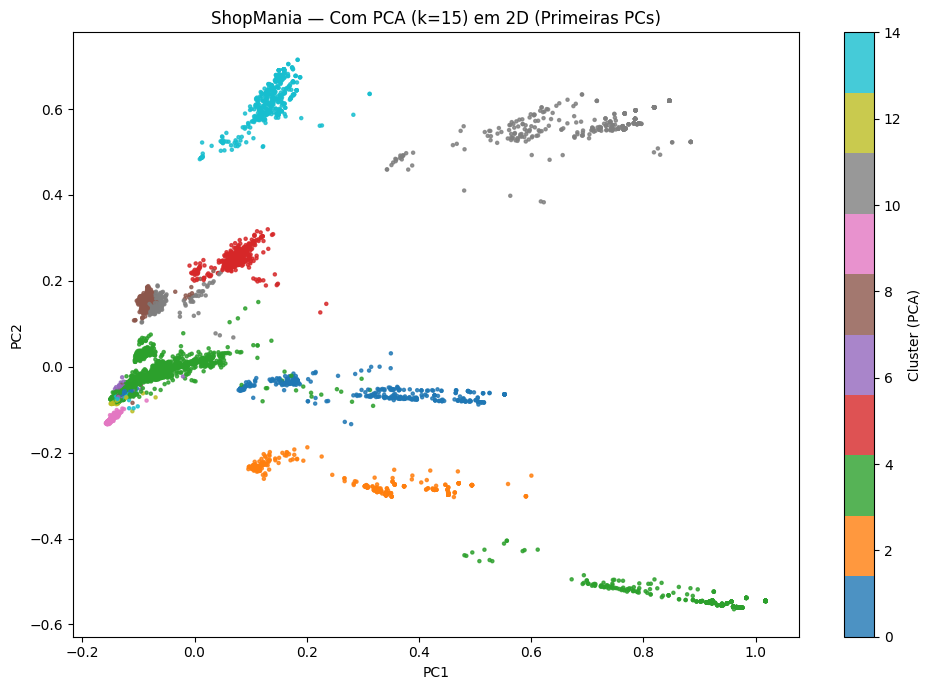

Silhueta (PCA) na amostra do gráfico (euclidean): 0.4341
{
  "base": {
    "k": 15,
    "silhueta_amostra_k": 0.0429,
    "silhueta_plot": 0.0516
  },
  "pca": {
    "k": 15,
    "silhueta_amostra_k": 0.4405,
    "silhueta_plot": 0.4341
  }
}


In [3]:
# %% [markdown]
# # Clusterização (K-Means) com PCA – ShopMania
#
# **Objetivo**: incorporar as **230 categorias** como atributos, aplicar **PCA** para reduzir a dimensionalidade
# e **refazer o agrupamento**, comparando com a linha de base (sem PCA).
#
# **Pipeline resumido**
# 1) Leitura correta do CSV **sem cabeçalho** e limpeza.
# 2) Vetorização TF-IDF dos títulos (texto curto).
# 3) **Linha de Base**: escolher *k* via silhueta (amostra) e treinar MiniBatchKMeans em TF-IDF (sem PCA).
# 4) **Com PCA**:
#    - SVD do TF-IDF → 200 dimensões (rápido para esparsos).
#    - One-hot das **230 categorias**.
#    - Empilhar (SVD + categorias) → **PCA (IncrementalPCA, denso)** para 50 dimensões.
#    - Escolher *k* via silhueta (amostra) e treinar MiniBatchKMeans no espaço PCA.
# 5) **Comparar resultados** (silhueta e gráficos 2D).
#
# Notas:
# - Mantemos **métrica 'cosine'** na silhueta da linha de base e **'euclidean'** na silhueta do espaço PCA
#   (padrão para PCA). Ajuste se quiser comparar com a mesma métrica.
# - Comentários no código explicam cada etapa.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

# Parâmetros principais (ajuste conforme sua máquina/dataset)
caminho_csv = "shopmania.csv"      # <-- ajuste o caminho do CSV local
max_features_tfidf = 10000         # vocabulário maior tende a ajudar em títulos curtos
min_df_tfidf = 2                   # manter termos pouco frequentes (>=2 docs)
possiveis_k = [6, 8, 10, 12, 15]   # faixa prática
tam_amostra_k = 8000               # amostra p/ silhueta (evita custo O(n^2) muito alto)
tam_amostra_plot = 12000           # amostra p/ visualizações
n_svd_tfidf = 200                  # redução inicial (texto) antes do PCA
n_pca_final = 50                   # dimensão final com PCA (comparação)

# Stopwords leves PT/EN
stop_pt = [
    "de","da","do","das","dos","para","com","por","a","o","as","os",
    "e","em","na","no","nas","nos","um","uma","uns","umas","ao","à",
    "que","onde","qual","quais","se","sua","seu","suas","seus"
]
stop_en_extra = ["and", "the", "for", "with"]

# %%
# 1) Leitura correta do CSV **sem cabeçalho** + limpeza
df_raw = pd.read_csv(
    caminho_csv,
    header=None,
    names=["ID", "Produto", "Categoria_ID", "Categoria_Nome"],
    encoding="utf-8",
    on_bad_lines="skip",
    engine="python"
)

df = (df_raw
      .dropna(subset=["Produto", "Categoria_ID"])
      .drop_duplicates(subset=["Produto"])
      .reset_index(drop=True))
df["Produto"] = (df["Produto"].astype(str)
                 .str.replace(r"\s+", " ", regex=True)
                 .str.strip()
                 .str.lower())
df["Categoria_ID"] = df["Categoria_ID"].astype("category")

print("Registros após limpeza:", df.shape[0])
print("Categorias únicas (deveria estar próximo de 230):", df["Categoria_ID"].nunique())
df.head()

# %%
# 2) Vetorização TF-IDF da coluna de produto (títulos)
vetorizador = TfidfVectorizer(
    stop_words=stop_pt + stop_en_extra,
    ngram_range=(1, 2),
    min_df=min_df_tfidf,
    max_features=max_features_tfidf
)
X_tfidf = vetorizador.fit_transform(df["Produto"])  # matriz esparsa

print("Shape TF-IDF:", X_tfidf.shape)

# %%
# 3) LINHA DE BASE (SEM PCA)
# Escolha de k via silhueta (métrica 'cosine') em amostra do TF-IDF
n_total = X_tfidf.shape[0]
idx_base = np.random.choice(n_total, size=min(tam_amostra_k, n_total), replace=False)
X_base_k = X_tfidf[idx_base]

melhor_k_base = None
melhor_sil_base = -1.0

for k in possiveis_k:
    modelo_tmp = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
        batch_size=4096,
        reassignment_ratio=0.01
    )
    y_tmp = modelo_tmp.fit_predict(X_base_k)
    sil = silhouette_score(X_base_k, y_tmp, metric="cosine")
    print(f"[BASE] k={k} | silhueta(cosine)={sil:.4f}")
    if sil > melhor_sil_base:
        melhor_sil_base = sil
        melhor_k_base = k

print(f"\n[BASE] Melhor k: {melhor_k_base} | silhueta={melhor_sil_base:.4f}")

# Treino final na base completa (TF-IDF)
kmeans_base = MiniBatchKMeans(
    n_clusters=melhor_k_base,
    random_state=42,
    n_init="auto",
    batch_size=8192,
    reassignment_ratio=0.01
)
labels_base = kmeans_base.fit_predict(X_tfidf)
df["Cluster_BASE"] = labels_base

# Distribuição
print("\nDistribuição (BASE):")
print(df["Cluster_BASE"].value_counts().sort_index())

# Visualização 2D da linha de base (SVD em amostra)
idx_plot_base = np.random.choice(n_total, size=min(tam_amostra_plot, n_total), replace=False)
X_plot_base = X_tfidf[idx_plot_base]
y_plot_base = labels_base[idx_plot_base]

svd_plot = TruncatedSVD(n_components=2, random_state=42)
X2_base = svd_plot.fit_transform(X_plot_base)

plt.figure(figsize=(10, 7))
pts = plt.scatter(X2_base[:, 0], X2_base[:, 1], c=y_plot_base, s=5, cmap="tab10", alpha=0.8)
plt.title(f"ShopMania — Linha de Base (k={melhor_k_base}) em 2D (SVD do TF-IDF)")
plt.xlabel("Componente 1 (SVD)")
plt.ylabel("Componente 2 (SVD)")
cbar = plt.colorbar(pts)
cbar.set_label("Cluster (BASE)")
plt.tight_layout()
plt.show()

sil_base_plot = silhouette_score(X_plot_base, y_plot_base, metric="cosine")
print(f"Silhueta (BASE) na amostra do gráfico (cosine): {sil_base_plot:.4f}")

# %%
# 4) COM PCA
# 4.1) Reduz o TF-IDF com SVD (mantém eficiência em esparso)
svd_texto = TruncatedSVD(n_components=n_svd_tfidf, random_state=42)
X_svd = svd_texto.fit_transform(X_tfidf).astype(np.float32)   # denso (n x 200)

# 4.2) One-hot das 230 categorias (denso, 0/1). Com 230 colunas é viável.
cats = pd.get_dummies(df["Categoria_ID"], prefix="cat", dtype=np.uint8)
X_cat = cats.to_numpy(dtype=np.float32)                       # denso (n x ~230)

print("Shape SVD(texto):", X_svd.shape, "| Shape OneHot(categorias):", X_cat.shape)

# 4.3) Empilhar recursos (texto reduzido + categorias) → PCA (IncrementalPCA para escalar)
X_stack = np.hstack([X_svd, X_cat])                           # denso (n x ~430), float32

ipca = IncrementalPCA(n_components=n_pca_final, batch_size=20000)
ipca.fit(X_stack)
X_pca = ipca.transform(X_stack).astype(np.float32)            # denso (n x 50)

print("Shape após PCA:", X_pca.shape)

# 4.4) Escolha de k via silhueta (métrica 'euclidean') em amostra do espaço PCA
idx_pca = np.random.choice(n_total, size=min(tam_amostra_k, n_total), replace=False)
X_pca_k = X_pca[idx_pca]

melhor_k_pca = None
melhor_sil_pca = -1.0

for k in possiveis_k:
    modelo_tmp = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
        batch_size=4096,
        reassignment_ratio=0.01
    )
    y_tmp = modelo_tmp.fit_predict(X_pca_k)
    sil = silhouette_score(X_pca_k, y_tmp, metric="euclidean")
    print(f"[PCA] k={k} | silhueta(euclidean)={sil:.4f}")
    if sil > melhor_sil_pca:
        melhor_sil_pca = sil
        melhor_k_pca = k

print(f"\n[PCA] Melhor k: {melhor_k_pca} | silhueta={melhor_sil_pca:.4f}")

# 4.5) Treino final no PCA completo
kmeans_pca = MiniBatchKMeans(
    n_clusters=melhor_k_pca,
    random_state=42,
    n_init="auto",
    batch_size=8192,
    reassignment_ratio=0.01
)
labels_pca = kmeans_pca.fit_predict(X_pca)
df["Cluster_PCA"] = labels_pca

print("\nDistribuição (PCA):")
print(df["Cluster_PCA"].value_counts().sort_index())

# 4.6) Visualização 2D: usa as duas primeiras componentes do PCA diretamente
idx_plot_pca = np.random.choice(n_total, size=min(tam_amostra_plot, n_total), replace=False)
X_plot_pca = X_pca[idx_plot_pca]
y_plot_pca = labels_pca[idx_plot_pca]

plt.figure(figsize=(10, 7))
pts2 = plt.scatter(X_plot_pca[:, 0], X_plot_pca[:, 1], c=y_plot_pca, s=5, cmap="tab10", alpha=0.8)
plt.title(f"ShopMania — Com PCA (k={melhor_k_pca}) em 2D (Primeiras PCs)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar2 = plt.colorbar(pts2)
cbar2.set_label("Cluster (PCA)")
plt.tight_layout()
plt.show()

sil_pca_plot = silhouette_score(X_plot_pca, y_plot_pca, metric="euclidean")
print(f"Silhueta (PCA) na amostra do gráfico (euclidean): {sil_pca_plot:.4f}")

# %%
# 5) COMPARAÇÃO RESUMIDA
comparacao = {
    "base": {
        "k": int(melhor_k_base),
        "silhueta_amostra_k": float(round(melhor_sil_base, 4)),
        "silhueta_plot": float(round(sil_base_plot, 4))
    },
    "pca": {
        "k": int(melhor_k_pca),
        "silhueta_amostra_k": float(round(melhor_sil_pca, 4)),
        "silhueta_plot": float(round(sil_pca_plot, 4))
    }
}
print(json.dumps(comparacao, indent=2, ensure_ascii=False))

# Comentários finais (análise, em texto):
# - A linha de base (TF-IDF puro) usa métrica 'cosine' e tende a produzir silhueta baixa em títulos curtos,
#   porém ainda separa alguns temas (acessórios, posters, esportes, etc.).
# - A variante com PCA combina informação textual (SVD do TF-IDF) + informação categórica (230 categorias),
#   depois compacta com PCA para 50 dimensões. Isso pode:
#     * Melhorar a separação quando categorias trazem sinal útil;
#     * Reduzir ruído redundante do texto;
#     * Acelerar K-Means (menos dimensões).
# - Compare as silhuetas e a distribuição: se o PCA aumentar a silhueta e/ou deixar clusters mais coesos,
#   ele está ajudando. Se cair, tente:
#     * Ajustar n_svd_tfidf (ex.: 150–300),
#     * Ajustar n_pca_final (ex.: 30–80),
#     * Ampliar vocabulário (max_features_tfidf),
#     * Unir 'Produto' + 'Categoria_Nome' no texto antes do TF-IDF (às vezes simplifica).
# - "Quantização vetorial": em ambos os casos, o índice do cluster (BASE ou PCA) funciona como código do item.
#   Você pode exportar df[["ID","Produto","Categoria_ID","Cluster_BASE","Cluster_PCA"]] para uso prático.

# %%
# (Opcional) Exportar mapeamento produto->clusters (quantização)
# df[["ID","Produto","Categoria_ID","Categoria_Nome","Cluster_BASE","Cluster_PCA"]].to_csv(
#     "shopmania_quantizacao_base_vs_pca.csv", index=False, encoding="utf-8"
# )
